In [74]:
# Use model file
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd 
from skimage import io, color
import os

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from PIL import Image
import tensorflow as tf

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

%matplotlib inline

In [75]:
#Function for GAN
def display(img):
    plt.figure()
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()


def combineLAB(l, a, b):
    shape = (l.shape[0], l.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = l
    zeros[:, :, 1] = a
    zeros[:, :, 2] = b
    return zeros


def combineAB(a, b):
    shape = (a.shape[0], b.shape[1], 2)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = a
    zeros[:, :, 1] = b
    return zeros


def combineL_AB(l, ab):
    shape = (l.shape[0], l.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = l
    zeros[:, :, 1] = ab[:, :, 0]
    zeros[:, :, 2] = ab[:, :, 1]
    return zeros


def make3channels(gray):
    shape = (gray.shape[0], gray.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = gray
    zeros[:, :, 1] = gray
    zeros[:, :, 2] = gray
    return zeros


def get_l_from_gray(img_path):
    img = io.imread(img_path)
    gray = color.rgb2gray(img)
    gray = make3channels(gray)
    lgray = color.rgb2lab(gray, illuminant='D50')[:, :, 0]
    return lgray


def get_ab_from_file(file):
    img = io.imread(file)
    ab = np.zeros((64, 64, 2))
    ab[:, :, 0] = img[:, :, 1]
    ab[:, :, 1] = img[:, :, 2]
    return ab


def lab_normal_image(path):
    l, ab = load_img_for_training(path)
    l, ab = (l-127.5)/127.5, (ab-127.5)/127.5
    return l, ab


def rgb_image(l, ab):
    l, ab = l*127.5 + 127.5, (ab*127.5)+127.5
    lab = combineL_AB(l, ab)
    rgb = color.lab2rgb(lab, illuminant='D50')
    return rgb


def load_img_for_training(img_path):
    img = io.imread(img_path)
    lab = color.rgb2lab(img, illuminant='D50')
    l, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]
    ab = combineAB(a, b)
    lgray = get_l_from_gray(img_path)
    return lgray, ab


def save_ab_file(image, filepath):
    # add in 0zeros to its first component
    shape = (image.shape[0], image.shape[1], 3)
    new_ab_image = np.zeros(shape)
    new_ab_image[:, :, 1] = image[:, :, 0]
    new_ab_image[:, :, 2] = image[:, :, 1]
    save_file(new_ab_image, filepath)


def save_file(image, filepath):
    io.imsave(filepath, image)


def load_ab_image(path):
    img = io.imread(path)
    shape = (img.shape[0], img.shape[1], 2)
    ab = np.zeros(shape)
    ab[:, :, 0] = img[:, :, 1]
    ab[:, :, 1] = img[:, :, 2]
    return ab

## Define Data

In [81]:
image_path = "/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Assignment/exam_input/"

gan_model = load_model('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Assignment/GAN.h5')
unet_model = load_model('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/Assignment/Unet.h5')

image_number = 15

## GAN

In [82]:
#GAN
def get_data(path):
    start = 1
    end = 1

    x_data = np.zeros((18000, 64, 64))
    y_data = np.zeros((18000, 64, 64, 2))

    for i in range(start, end+1):
        filename = path + str(image_number) + ".jpg"
        l, ab = lab_normal_image(filename)
        x_data[i-1] = l
        y_data[i-1] = ab

    return x_data, y_data


x_data,y_data = get_data(image_path)
x_data = x_data.reshape((18000,64,64,1))
samples = x_data[0:1]
ab_values = gan_model.predict(samples)
l_val = samples[0][:,:,0]
ab_val = ab_values[0]
gan_result = rgb_image(l_val, ab_val)

## U-Net

In [83]:
class ColorizationDataset(Dataset):
    def __init__(self, image_size, cuda=False):
        self.image_size = image_size
        self.cuda = cuda
    def __len__(self):
        return len(os.listdir(image_path))

    def __getitem__(self, idx):
        with Image.open(f'{image_path+str(image_number)}.jpg') as image:
            img = image.copy()
            
        compose_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        Y = compose_transforms(img)
        X = (Y[0] * 0.299 + Y[1] * 0.587 + Y[2] * 0.114).reshape(1, 64, 64)
        if self.cuda:
            X = X.to(device)
            Y = Y.to(device)
        return X, Y

dset = ColorizationDataset(64)
batch_size = 32
dataset, _ = torch.utils.data.random_split(dset, [int(len(dset)/4), len(dset)-int(len(dset)/4)])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def to_numpy_image(img):
    img = img.cpu()
    return img.detach().transpose(0, 1).transpose(1, 2).numpy()


x,y = dset.__getitem__(len(dset)-0-1)
x = x.numpy().reshape(-1,64,64,1)

y_pred = torch.from_numpy(unet_model.predict(x))
aff = (y_pred.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy()

## Show Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'GAN')

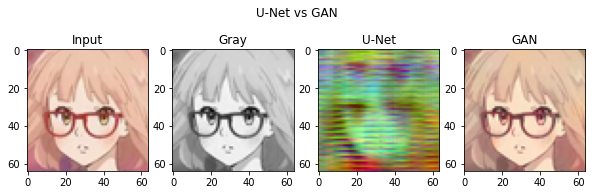

In [84]:
fig = plt.figure(figsize=(10, 3))
fig.suptitle("U-Net vs GAN")
rows = 1
columns = 4

image_path = image_path + str(image_number) +".jpg"

#Image preparation
#orignal rgb
original = plt.imread(image_path)

#gray image
gray = np.zeros((1, 64, 64))
ab = np.zeros((1, 64, 64 ,2))
gray[0], ab[0] = lab_normal_image(image_path)
original_gray = gray[0]

#Show image
fig.add_subplot(rows, columns, 1)
plt.imshow(original)
plt.title("Input")


fig.add_subplot(rows, columns, 2)
plt.imshow(original_gray, cmap="gray")
plt.title("Gray")


fig.add_subplot(rows, columns, 3)
plt.imshow(aff)
plt.title("U-Net")

fig.add_subplot(rows, columns, 4)
plt.imshow(gan_result)
plt.title("GAN")